<a href="https://colab.research.google.com/github/ngzhiwei517/NLP/blob/main/Lecture_03_n_Gram_Language_Models_(basic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 03 - n-Gram Language Models (basic)

This notebook covers the very basic idea behind Language Models. To this end, we implement the toy example from the lecture. The goal here is to show that training an n-Gram Language Model really just boils down to going through a text and counting the occurrences of n-grams for using Maximum Likelihood Estimation to compute the conditional probabilities.

Of course, in practice, things can quickly become more complicated when (advanced) smoothing techniques are considered. But even then, the underlying requirement is counting the occurrences of bigrams. We use simple Add-k Smoothing to give an example as this technique -- compared to, e.g., Kneser-Ney Smoothing -- is a trivial extensions to the basic concept of a n-Gram Language Model.

Let's get started...

### Required Imports

We'll use spaCy to handle the basics such as tokenization. Given the toy example containing only 3 sentences without punctuation marks, hyphenated words, abbreviations, or anything else that would make tokenization in any sense challenging, using spaCy is kind of over kill. However, this makes it easy to extend the corpus with your own sentences without worrying about the correct tokenization.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
import spacy
from nltk.util import bigrams
from collections import defaultdict

#remove punctuations in this case and turn all the words to lower case
nlp = spacy.load("en_core_web_sm")
text = "I love cake. I love coffee. I enjoy cake."
tokens = [token.text.lower() for token in nlp(text) if not token.is_punct]

print(tokens)

['i', 'love', 'cake', 'i', 'love', 'coffee', 'i', 'enjoy', 'cake']


NLTK comes with some convenient methods the generate bigrams and trigrams which also handle the padding, i.e., the adding of start-of-sentence and end-of-sentence tokens.

In [ ]:
from nltk.util import trigrams, bigrams
from collections import defaultdict
#defaultdict is a special dictionary from the collections module.
#It allows you to set a default value for missing keys, which is ideal for
# counting occurrences of n-grams without worrying about missing entries.


## Training the Language Model

Training a n-Gram Language Model is all about keeping counts of all n-grams found in a text. Here, we do this on a sentence-by-sentence basis. The method `process_sentence` below takes a sentence `s` and the current n-gram counts, goes through all n-grams in the sentence, and updates the n-gram counts accordingly. We also keep track of the vocabulary as we need the size of the vocabulary for smoothing.

Note that we use a `defaultdict` instead of a standard dictionary here. This is purely for convenience, since we don't need to check if a key (i.e., a n-gram) is already present in the dictionary before updating the count. This just saves a couple of lines of code.

In [ ]:
def process_sentence(s, ngram_counts, vocabulary, ngram_size=2):
    #ngram_counts: A defaultdict used to store the counts of each n-gram
    #and their contexts.

    # Let spaCy handle the tokenization
    doc = nlp(s)
    # Get the individual text tokens
    tokens = [ t.text for t in doc]

    # Update vocabulary
    vocabulary.update(set(tokens))

    # Since we want to keep the simple here, we let NLTK to the generation of all ngram incl. the padding
    # However, NLTK does this out of the box only for bigrams and trigrams, so let's limit ourselves here
    if ngram_size == 2:
        ngrams = bigrams
    elif ngram_size == 3:
        ngrams = trigrams
    else:
        raise Exception('Unsupported ngram size: either 2 or 3')

#Generate n-grams with padding
#Padding: Adds special start (<s>) and end (</s>) tokens for each sentence.

    for ngram in ngrams(tokens, pad_left=True, pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
    #This uses the ngrams() function from NLTK, which directly generates n-grams from the input token list
          context = ngram[:-1]
            #The context is everything except the last word.
          ngram_counts[context] += 1
          ngram_counts[ngram] += 1

tokens = ['I', 'am', 'Sam']

With padding, the generated bigrams would be:


    ('<s>', 'I'),
    ('I', 'am'),
    ('am', 'Sam'),
    ('Sam', '</s>')



📝 Example with Duplicate Words
Consider the sentence "Sam I am Sam I am":


    ('<s>', 'Sam'),
    ('Sam', 'I'),
    ('I', 'am'),
    ('am', 'Sam'),
    ('Sam', 'I'),
    ('I', 'am'),
    ('am', '</s>')




```
Context Counts:

('<s>',): 1 (start token)
('Sam',): 2 ('Sam I' twice)
('I',): 2 ('I am' twice)
('am',): 2 ('am Sam' twice)

n-Gram Counts:

('<s>', 'Sam'): 1
('Sam', 'I'): 2
('I', 'am'): 2
('am', 'Sam'): 1
('am', '</s>'): 1
```



Now we're ready to go to train the Language Model. We use the very small toy corpus from the lecture:

```
I am Sam
Sam I am
I do not like green eggs and ham
```

which is stored in the file `'data/toy-example-data.txt`. Feel free to modify and/or extend this corpus with sentences of your own. The only requirement is that each sentence must be in its own line in the file. Otherwise the following code would need a little bit of tweaking

So let's just read the file and go through all the sentences and use method `process_sentence` to update our n-gram counts which are stored in `ngram_counts`.

In [15]:
# Initialize n-gram counts; using a defaultdict, the default count for missing keys/ngrams is 0
ngram_counts = defaultdict(int)
vocabulary = set()

ngram_size = 2
#ngram_size = 3

with open('/content/toy-example-data.txt', 'r') as file:
    # Loop over each line in the file (1 line = 1 sentence)
    for sentence in file.read().split('\n'):
        # Update n-gram counts using our auxiliary method
        process_sentence(sentence, ngram_counts, vocabulary, ngram_size=ngram_size)

# Display the final n-gram counts
ngram_counts

defaultdict(int,
            {('<s>',): 3,
             ('<s>', 'I'): 2,
             ('I',): 3,
             ('I', 'am'): 2,
             ('am',): 2,
             ('am', 'Sam'): 1,
             ('Sam',): 2,
             ('Sam', '</s>'): 1,
             ('<s>', 'Sam'): 1,
             ('Sam', 'I'): 1,
             ('am', '</s>'): 1,
             ('I', 'do'): 1,
             ('do',): 1,
             ('do', 'not'): 1,
             ('not',): 1,
             ('not', 'like'): 1,
             ('like',): 1,
             ('like', 'green'): 1,
             ('green',): 1,
             ('green', 'eggs'): 1,
             ('eggs',): 1,
             ('eggs', 'and'): 1,
             ('and',): 1,
             ('and', 'ham'): 1,
             ('ham',): 1,
             ('ham', '</s>'): 1})

🧮 Total = 11 context-only entries
🧮 Total = 15 full bigram entries

In [16]:
V = len(vocabulary)

print("Numner of n-grams: {}".format(len(ngram_counts)))
print("Size of vocabulary: {}".format(V))

Numner of n-grams: 26
Size of vocabulary: 10


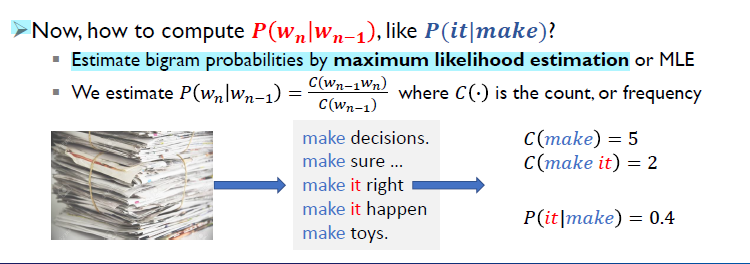

## Calculating Probabilities

With all the n-gram counts, we can now compute the conditional probabilities using Maximum Likelihood Estimation as defined in the lecture. We also saw that Add-k Smoothing was a very simple extension. The method `calc_prob` below computes the probability of an n-gram; the Add-k Smoothing is optional.

In [17]:
def calc_prob(ngram, ngram_counts, k=0, V=0):
    # Convert the n-gram from a list to a tuples so we can use it as a key for our n-gram counts dictionary
    ngram = tuple(ngram)
    # Get the context, i.e., the n-gram without the last word
    context = ngram[:-1]
    # Calculate and return the probability using Maximum Likelihood Estimation
    # We wrap the calculation in a TRY-CATCH block to handle divisions by zero if the context count is 0
    try:
        return (ngram_counts[ngram] + k) / (ngram_counts[context] + k*V)
    except Exception as e:
        return 0.0

### Bigram Examples

Let's first calculate the bigram probabilities we used in the lecture. Note that these examples only work if you trained the Language Model with bigrams.

In [18]:
print(calc_prob(['<s>', 'I'], ngram_counts))
print(calc_prob(['I', 'am'], ngram_counts))
print(calc_prob(['am', 'Sam'], ngram_counts))
print(calc_prob(['Sam', '</s>'], ngram_counts))

0.6666666666666666
0.6666666666666666
0.5
0.5


We can also compute the probabilities using Add-k Smoothing (e.g., Laplace Smoothing with $k=1$). The method `calc_prob` is ready for that.

In [23]:
k = 1

print(calc_prob(['<s>', 'I'], ngram_counts, k=k, V=V)) #3/13
print(calc_prob(['I', 'am'], ngram_counts, k=k, V=V))
print(calc_prob(['am', 'Sam'], ngram_counts, k=k, V=V))
print(calc_prob(['Sam', '</s>'], ngram_counts, k=k, V=V))

0.23076923076923078
0.23076923076923078
0.16666666666666666
0.16666666666666666


You can see how the probabilities drop when using smoothing as we move probability mass from n-grams with zero counts to all n-grams with non zero counts. The smaller you make k, the less probability mass is moved; try $k=0.1$ to see the difference.

### Trigram Examples

If you train the Language Model using trigrams, you can check out the example below. The code cell still works after training a bigram model, but the probabilities will of course be 0 (at least without smoothing).

In [24]:
print(calc_prob(['<s>', 'I', 'am'], ngram_counts))
print(calc_prob(['I', 'am', 'Sam'], ngram_counts))
print(calc_prob(['<s>', 'Sam', 'I'], ngram_counts))
print(calc_prob(['am', 'Sam', '</s>'], ngram_counts))

0.0
0.0
0.0
0.0


And again, the same with smoothing

In [ ]:
k = 0.1

print(calc_prob(['<s>', 'I', 'am'], ngram_counts, k=k, V=V))
print(calc_prob(['I', 'am', 'Sam'], ngram_counts, k=k, V=V))
print(calc_prob(['<s>', 'Sam', 'I'], ngram_counts, k=k, V=V))
print(calc_prob(['am', 'Sam', '</s>'], ngram_counts, k=k, V=V))

0.03333333333333333
0.03333333333333333
0.05
0.05


## Summary

The basic idea behind training a n-Gram Language Model is indeed quite straightforward: just count the occurrences of all n-grams. Of course, here we purposefully ignored all challenges that come when training a Language Model over a very large corpus. Most importantly, the number of unique n-grams quickly increases, even exponentially w.r.t. the size of the n-grams.

Still, basically all changes needed to the code above would address this challenges of handling a very large text corpus. The basic algorithm of going through the corpus and keeping track of all n-gram counts would remain exactly the same.